# Simulation of the growth and development of an apple tree 1 - Organ Development

# Generating organ shape

We will create a textured module. For this you need the [leaf](./appleleaf.png) and [flower](flower.png) images.
You should complete this [lsystem file](./organshape.lpy).

![metamer](./metamer.png)

- Define a New `Curve2d` in `Panel 1`, give it a shape in V and name it `leafsection`.
- Import the image `apple-leaf.png` as a texture in position 10 in the `Color Map` panel.
- Complete the interpretation rule of Leaf to generate a textured polygon
  * Generate a turtle draw of length `length` and of width `width/2` with section `leafsection`
  * Apply color 10.
  * Set the of the texture with module `TextureVScale`.


Solution can be found [here](./organshape-solution.lpy).

# Modelling organ growth

## Loading meteo data

In [3]:
# Loading meteo data
import meteo ; reload(meteo)
from meteo import *
init_temperatures()

In [4]:
# Example of Use

get_temperature(date(2010,1,1))

from matplotlib.pyplot import *

plot(get_all_dates(), get_all_temperatures())
show()

<Figure size 640x480 with 1 Axes>

## Modelling thermal time

Thermal time consists in accumulating each day the temperature above a given base temperature $t_0$. 

<center>
    $tt = \sum_{t}{t-t_0}$
</center>

In [8]:
base_temperature = 5

class ThermalTime:
    def __init__(self, base_temperature):
        self.base_temperature = base_temperature
    def get_effective_temperature(self, cdate):
        ctemp = get_temperature(cdate)
        return max(0, ctemp-self.base_temperature)
    def get_effective_temperatures(self, beg_date, end_date):
        return [max(0,ctemp-self.base_temperature) for ctemp in get_temperatures(beg_date, end_date)]

# a global variable that makes it possible to compute effective temperature
mthermaltime = ThermalTime(base_temperature)

## Organ final size

We distinguish the organ produced at the begining of the growth unit (preformed) from the other ones.

In [9]:
# Parameters
FinalLeafArea1 = 12.
FinalLeafArea2 = 25.

InternodeLength1 = 1
InternodeMaxLength = 2.0

InternodeRadius = 0.3 

In [10]:
def leaf_area(rank):
    if rank < 7:
        return FinalLeafArea1
    else:
        return FinalLeafArea2

def internode_length(rank, maxlength = InternodeMaxLength):
    if rank < 7:
        return maxlength/3
    else:
        return maxlength        

## Organ expansion

Growth will be modelled with a logistic function of the shape.

<center>
$ s(t) = \frac{A}{1+exp^{-\frac{t-t_{ip}}{b}}}$
</center>

With $A$ the maximum size, $t_{ip}$ the time at inflexion point and $b$ a slope parameter.
Its derivatives that gives the rate of growth will be

<center>
$ \frac{ds}{dt} = \frac{A.exp^{-\frac{t-t_{ip}}{b}} }{ b.(1+exp^{-\frac{t-t_{ip}}{b}})^2}$
</center>


In [7]:
from math import exp

def growth_logistic(ttime, finalsize, tip, b):
    return finalsize / (1 + exp(-(ttime-tip)/b ))

def growth_logistic_at_date(begdate, cdate, finalsize, tip, b):
    ttime = sum(mthermaltime.get_effective_temperatures(begdate, cdate))
    return growth_logistic(ttime, finalsize, tip, b)

def growth_rate(ttime, finalsize, tip, b):
    g = exp(-(ttime-tip)/b )
    return (finalsize * g)  / ( b * pow((1+g),2))


def growth_rate_at_date(begdate, cdate, finalsize, tip, b):
    ttime = sum(mthermaltime.get_effective_temperatures(begdate, cdate))
    return growth_rate(ttime, finalsize, tip, b)

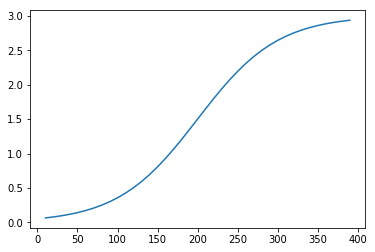

In [14]:
r = range(10, 400, 10)
plot(r, [growth_logistic(ttime, 3, 200, 50.) for ttime in r])
show()

We can parameterize the previous function with the following value for the leaf and internode.

In [12]:
# Parameters
tip_leaf = 100.
tip_internode = 100.

b_leaf = 30.
b_internode = 30.

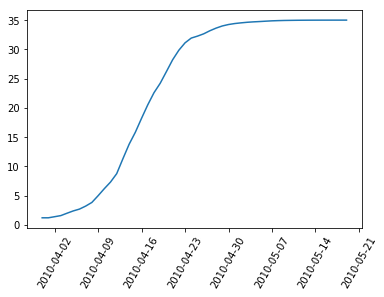

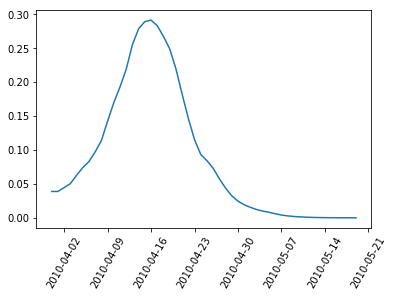

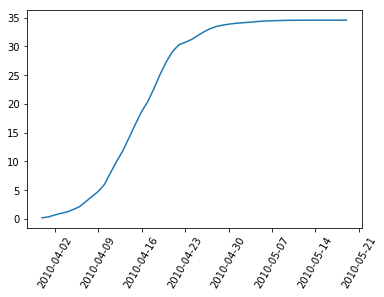

In [18]:
# Example of Use
begdate = date(2010,4,1)
growthperiod = [begdate+timedelta(days=i-1) for i in xrange(50)]

plot(growthperiod, map(lambda d : growth_logistic_at_date(begdate, d, FinalLeafArea2, tip_leaf, b_leaf), growthperiod))
xticks(rotation= 60)
show()

rate = list(map(lambda d : growth_rate_at_date(begdate, d, FinalLeafArea2, tip_leaf, b_leaf), growthperiod))
plot(growthperiod, rate)
xticks(rotation= 60)
show()

from numpy import dot, cumsum
integration = [a*b for a,b in zip(mthermaltime.get_effective_temperatures(begdate, begdate+timedelta(days=50)),rate)]
plot(growthperiod, cumsum(integration))
xticks(rotation= 60)
show()

## Modeling organ development

Using L-Py and the previous equations, we will model the developement of leaves and internodes.

Open and complete in L-Py [the model of organ growth](./organdevelop.lpy)

# Modeling growth units development

## Growth unit length

In [1]:
from namedenum import enum
enum('ShortGU', 'LongGU', 'Inflo', 'TrunkGU', 'Blind')

gulengthlaw = { 
    ShortGU : (5, 0.5),
    LongGU : (18, 7),
    Inflo : (3, 0.2),
    TrunkGU : (50, 6.5)
              }

from random import gauss

def growth_unit_length(gutype, parentlength = None):
    mean, sd = gulengthlaw[gutype]
    res = int(gauss(mean,sd))
    if parentlength != None and gutype == LongGU:
        parentlength *= 0.9
        while parentlength < res:
            res = int(gauss(mean,sd))
    return res


## Growth Unit production

The rate of production of metamers by the apex of the GU is given with the following equation

$R_i(d) = r_i * T_{eff}(d)$ if $N_i(d)<N_{f,i}$ and $d < D_e$

       = 0 else

with $r_i$ the rate of metamer production in thermal time, $T_{eff}(d)$ the accumulated thermal time at date $d$, $N_{f,i}$ the final number of metamer and $D_e$ the date of plant growth arrest.

This equation will be modeled by the `MetamerProduction` structure that will accumulate thermal time and determine the number of metamer to produce accordingly.

In [42]:
metamerprodrate = 0.05
date_end_production = 252

In [43]:
class MetamerProduction:
    def __init__(self, rate, nbfinalmetamer, maxdate = date_end_production):
        self.rate = rate
        self.nbfinalmetamer = nbfinalmetamer
        self.nbmetamer = 0
        self.maxdate = maxdate
        
    def accumulate(self, cdate):
        ttime = mthermaltime.get_effective_temperature(cdate)
        if self.nbmetamer < self.nbfinalmetamer and (cdate -date(cdate.year,1,1)).days < self.maxdate :
            production = self.rate*ttime
            prevnbmetamer = int(self.nbmetamer)
            self.nbmetamer += production
            if int(self.nbmetamer) >  prevnbmetamer:
                return int(self.nbmetamer) - prevnbmetamer
            return 0
        return 0
    
    def accumulate_range(self, prevdate, cdate):
        sumi = 0
        for i in xrange(1,(cdate-prevdate).days+1):
            sumi += self.accumulate(prevdate+timedelta(days=i))
        return sumi

## Modeling GU development

Open in L-Py [the model axis.lpy](./axis.lpy).

Complete the rule for meristem.



To continue, you should look at the [notebook on architecture](./Apple Tree Simulation - Architecture.ipynb).